Implementing the method described in “Joseph, K., Tan, C. H., & Carley, K. M. (2012). [Beyond “Local”, “Categories” and “Friends”: Clustering Foursquare Users with Latent “Topics.”](http://dl.acm.org/citation.cfm?id=2370422) UbiComp'12 (pp. 919–926). doi:10.1145/2370216.2370422”

In [1]:
from pymongo import MongoClient
from collections import defaultdict
import scipy.io as sio
import scipy.sparse as sp
import gensim
import pandas as pd
import sys
sys.path.append('..')
import persistent as p
from scipy.spatial import ConvexHull
import shapely.geometry as geom
import folium

Pull the venues out of the DB

In [2]:
cl = MongoClient()
db = cl.combined
fullcity, city = 'San Francisco', 'sanfrancisco'
scaler = p.load_var('../sandbox/paper-models/{}.scaler'.format(city))
venue_infos = {}
for venue in db.venues.find({ "bboxCity": fullcity}):
    venue_infos[venue['_id']] = (venue['coordinates'], venue['name'], None if len(venue['categories']) == 0 else venue['categories'][0])

/home/chercheur/geraud/venvs/chr351/lib/python3.5/site-packages/sklearn/utils/fixes.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


Read checkins to start building the venues×users matrix

In [3]:
user_visits = defaultdict(lambda : defaultdict(int))
venue_visitors = defaultdict(lambda : defaultdict(int))

for vid in venue_infos:
    for checkin in  db.checkins.find({"venueId": vid}):
        uid = checkin['foursquareUserId']
        user_visits[uid][vid] += 1
        venue_visitors[vid][uid] += 1

user_visits = {us: {vn: c for vn, c in usval.items()} for us, usval in user_visits.items()}
venue_visitors = {us: {vn: c for vn, c in usval.items()} for us, usval in venue_visitors.items()}

Then apply the pruning described in the paper


>  In addition, we remove those users with less than 5 unique venue check ins and those venues with less than 10 check ins, repeating the pruning iteratively until all such venues and users are removed.

In [4]:
still_work_todo = True
print(len(user_visits), len(venue_visitors))
while still_work_todo:
    users_to_remove = set()
    new_users = {}
    for u, vst in user_visits.items():
        rvst = {vid: num for vid, num in vst.items() if vid in venue_visitors}
        num_visit = len(rvst.values())
        if num_visit < 5:
            users_to_remove.add(u)
        else:
            new_users[u] = dict(rvst)
    #print(len(users_to_remove), len(new_users))
    venues_to_remove = set()
    new_venues = {}
    for u, vst in venue_visitors.items():
        rvst = {user: num for user, num in vst.items() if user in new_users}
        num_visit = sum(rvst.values())
        if num_visit < 10:
            venues_to_remove.add(u)
        else:
            new_venues[u] = dict(rvst)
    #print(len(venues_to_remove), len(new_venues))
    user_visits = new_users
    venue_visitors = new_venues
    still_work_todo = len(users_to_remove) > 0 or len(venues_to_remove) > 0
print('At the end of the pruning, we are left with {} unique users who have made {} checkins in {} unique venues'.format(len(user_visits), sum(map(len, user_visits.values())), len(venue_visitors)))

20443 22376
At the end of the pruning, we are left with 8989 unique users who have made 214583 checkins in 6198 unique venues


Build the corpus using [gensim](https://radimrehurek.com/gensim/tut1.html). There, each user is a “document” represented by a bag of words, where “words” are venues.

I also remove a few venues appearing to often (in more than 8% of the total number of users, like railway station) but maybe that's no so smart… To quote the paper:

> In the text modeling domain, “stop words” are often removed, words such as “a”
and “the” which are highly frequent. It might behoove a model of places to do
the same. However, while it might make sense to remove uninteresting places
such as airports and bus stations, it is unclear if popular places
representative of interests, like stadiums, should really be removed. While we
considered this avenue, we did not obtain rigorous findings in this direction.

In [5]:
sorted_venues = {v: i for i, v in enumerate(sorted(venue_visitors))}
sorted_users = sorted(user_visits) 
write_doc = lambda vst: [v for v, c in vst.items() for _ in range(c)]

texts = [write_doc(user_visits[uid]) for uid in sorted_users]

dictionary = gensim.corpora.Dictionary(texts)
print(dictionary)
dictionary.filter_extremes(no_below=0, no_above=.08, keep_n=None)
print(dictionary)
corpus = [dictionary.doc2bow(text) for text in texts]
gensim.corpora.MmCorpus.serialize('{}_corpus.mm'.format(city), corpus)
dictionary.save('{}_venues_dict.dict'.format(city))

Dictionary(6198 unique tokens: ['4a898355f964a520350820e3', '4ac6b79af964a520fab520e3', '4b76efbff964a520406c2ee3', '40b52f80f964a52061001fe3', '4a6265bcf964a520f2c31fe3']...)
Dictionary(6191 unique tokens: ['4a898355f964a520350820e3', '4ac6b79af964a520fab520e3', '49f226d4f964a520026a1fe3', '4b76efbff964a520406c2ee3', '40b52f80f964a52061001fe3']...)


They don't mention anything about tf-idf so let's not do it

On the other hand, there is some indication for the number of topics

>  In the case studies below, we set the number of hidden topics to be twenty. We complete sensitivity tests, as suggested in [3], and find that our model is most effective and most interpretable when we use twenty clusters

In [6]:
%time model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=dictionary, workers=10, num_topics=20)

CPU times: user 5.92 s, sys: 324 ms, total: 6.25 s
Wall time: 6.04 s


Display the top venues in some topic, keeping in mind there's not topic ordering

> Unlike LSA, there is no natural ordering between the topics in LDA. The returned subset of all topics is therefore arbitrary and may change between two LDA training runs.

In [7]:
venues_per_topic = 10
num_topics = 5
index_name = [['Topic {}'.format(i+1) for i in range(num_topics) for _ in range(venues_per_topic) ],
          [str(_) for i in range(num_topics) for _ in range(venues_per_topic) ]]

res =[]

for topic in range(num_topics):
    for vidx, weight in model.get_topic_terms(topic, venues_per_topic):
        vid = dictionary.id2token[vidx]
        name = venue_infos[vid][1]
        link = 'https://foursquare.com/v/'+vid
        cat = venue_infos[vid][2]['name']
        res.append([name, cat, weight, link])

pd.DataFrame(res, index=index_name, columns=['Venue', 'Category', 'Weight', 'URL'])

Venue  \
Topic 1 0                 Montgomery St. BART Station   
        1                           Fitness SF Castro   
        2                          Blue Bottle Coffee   
        3                                  Salesforce   
        4                          Blue Bottle Coffee   
        5                              The Lusty Lady   
        6                                 Tapjoy Inc.   
        7                     Powell St. BART Station   
        8                                  Twitter HQ   
        9                                 WeWork SOMA   
Topic 2 0              Westfield San Francisco Centre   
        1                         Sumazi.com World HQ   
        2                             Vara Apartments   
        3                   The Amazing Sumazi.com HQ   
        4         Century San Francisco Centre 9 & XD   
        5                           The Corner Studio   
        6                                     Pier 39   
        7                             24 Hour Fitness   
        8                             AMC Van Ness 14   
        9                             24 Hour Fitness   
Topic 3 0                             24 Hour Fitness   
        1                     Rogue Ales Public House   
        2              Westfield San Francisco Centre   
        3                             24 Hour Fitness   
        4                                      Butter   
        5                 Montgomery St. BART Station   
        6                                  Twitter HQ   
        7          Hult International Business School   
        8                             AMC Van Ness 14   
        9  U.S. Environmental Protection Agency (EPA)   
Topic 4 0                          Whole Foods Market   
        1            San Francisco-Oakland Bay Bridge   
        2              Louise M. Davies Symphony Hall   
        3                                Moscone West   
        4                                Deddy's home   
        5                             24 Hour Fitness   
        6                                       Adobe   
        7                             CBS Interactive   
        8         21st Amendment Brewery & Restaurant   
        9                                Midnight Sun   
Topic 5 0                           Fitness SF Castro   
        1                             FITNESS SF SoMa   
        2                     Sundance Kabuki Cinemas   
        3                          Whole Foods Market   
        4                            Candlestick Park   
        5              Louise M. Davies Symphony Hall   
        6                       City of San Francisco   
        7                                     Lookout   
        8                                       Cabin   
        9                              Cathay Pacific   

                                           Category    Weight  \
Topic 1 0                             Metro Station  0.014999   
        1                                       Gym  0.007627   
        2                               Coffee Shop  0.006722   
        3                                    Office  0.006557   
        4                               Coffee Shop  0.004590   
        5                                Strip Club  0.004576   
        6                              Tech Startup  0.003762   
        7                             Metro Station  0.003676   
        8                                    Office  0.003603   
        9                           Coworking Space  0.003601   
Topic 2 0                                      Mall  0.005822   
        1                              Tech Startup  0.005731   
        2  Residential Building (Apartment / Condo)  0.005404   
        3                              Tech Startup  0.005277   
        4                                 Multiplex  0.004943   
        5                      Gym / Fitness Center  0.004633   
        6                          

How much venues are needed in each topic to reach 15% of the probability mass?

In [8]:
weights = np.array([[_[1] for _ in model.get_topic_terms(i, 500000)] for i in range(20)])

In [9]:
top_venues_per_topic = (weights.cumsum(-1)>.15).argmax(1)
top_venues_per_topic

array([54, 59, 47, 42, 34, 57, 53, 36, 33, 49, 60, 50, 54, 49, 54, 60, 45, 46, 25, 56])

In [14]:
mf = folium.Map(location=[37.76,-122.47])
feats=[]
for topic, num_venues in enumerate(top_venues_per_topic):
    pts=[]
    for vidx, _ in model.get_topic_terms(topic, num_venues):
        vid = dictionary.id2token[vidx]
        pts.append(venue_infos[vid][0])
    pts = np.array(pts)

    spts = scaler.transform(pts)

    hull = pts[ConvexHull(spts).vertices, :]

    geojson_geo = geom.mapping(geom.Polygon(hull))
    feats.append({ "type": "Feature", "geometry": geojson_geo, "properties": {"fill": "#BB900B"}})

_=folium.GeoJson({"type": "FeatureCollection", "features": feats},
                 style_function=lambda x: {
                     'opacity': 0.2,
                     'fillColor': x['properties']['fill'],
                 }).add_to(mf)

Although their method is nice, the main problem is that disregarding spatial info makes it very difficult to compare with us. 

Here I tried to plot the convex hull of the top venues of each topic and it basically cover the whole city so…

They justify it as follow:

> While the dataset gives a diverse set of information, we describe each user
simply by the places they go and how often they go there, thus choosing to
ignore geospatial and social information which exists in the data.  In
addition, we ignore information on the category of different places, as
explained in later section.

> In addition, by not specifying any presumed factors to be responsible for
similar check in locations between users, we avoid restrictions of the types of
groups our model might find.  For example, explicitly using geo-spatial
features may restrict our ability to understand groups of users with similar
interests which are spread throughout a city, such as the tourists described
above.

Another limitation they give which we partially lift is temporal aspect:

> One clear limitation of our model - by ignoring temporal information in the
data, we assume that groupings of users (and thus the factors affecting their
check in behaviors) are heavily static, which is likely not the case. Topic
models which consider temporal information, such as periodicity [25], may be
able to garner interesting clusters over time.

In [15]:
mf

In case the live javascript map doesn't show up, below is a static screenshot of it…

In [18]:
from IPython.display import Image

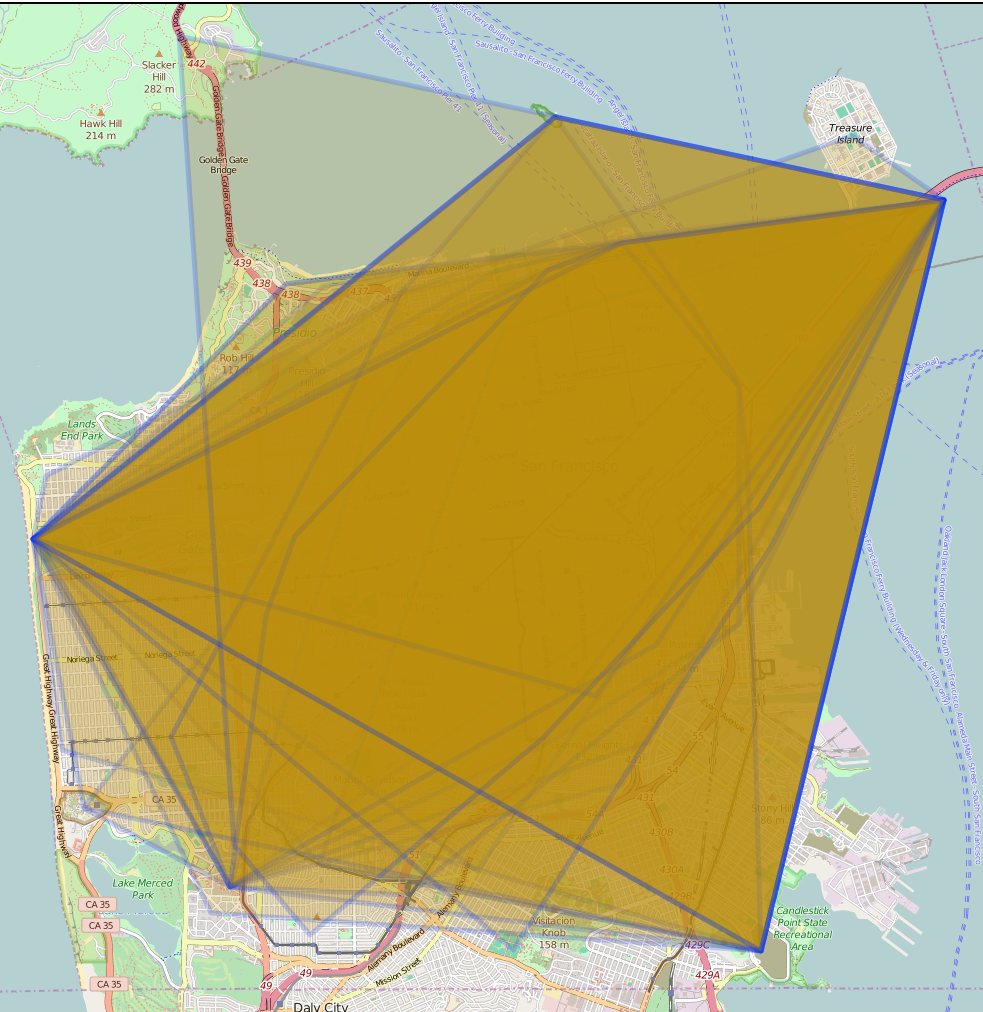

In [19]:
Image('sf_ref44_static.png')